<a href="https://colab.research.google.com/github/Minjule/registration-sys/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file_path = "C:\\Users\\Acer\\Desktop\\academy\\ocular desease recognition\\splitted.zip"
with ZipFile(file_path, 'r') as zip_file:
  zip_file.extractall()
  print('Extraction Completed')

Extraction Completed


In [2]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
train_dir = "C:\\Users\\Acer\\Documents\\GitHub\\registration-sys\\splitted\\train"
test_dir = "C:\\Users\\Acer\\Documents\\GitHub\\registration-sys\\splitted\\test"

train_datagen = ImageDataGenerator()  # You can add data augmentation here if needed
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size=(250, 250),
    batch_size=4,
    class_mode='sparse',
    shuffle=True,
    classes={'ageDegeneration': 0, 'cataract': 1,'diabetes': 2, 'glaucoma':3, 'hypertension':4, 'myopia':5, 'normal':6, 'others':7}
    )

test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size=(250, 250),
    batch_size=4,
    class_mode='sparse',
    shuffle=False,
    classes={'ageDegeneration': 0, 'cataract': 1,'diabetes': 2, 'glaucoma':3, 'hypertension':4, 'myopia':5, 'normal':6, 'others':7}
    )

# shuffle=True will shuffle the images and labels within each batch
#  but the correspondence between the images and labels will be maintained.

Found 5110 images belonging to 8 classes.
Found 643 images belonging to 8 classes.


In [7]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

In [9]:
print('ageDegeneration: ',len(np.where(total_image==0)[0]))
print('cataract: ',len(np.where(total_image==1)[0]))
print('diabetes: ',len(np.where(total_image==2)[0]))
print('glaucoma: ',len(np.where(total_image==3)[0]))
print('hypertension: ',len(np.where(total_image==4)[0]))
print('myopia: ',len(np.where(total_image==5)[0]))
print('normal: ',len(np.where(total_image==6)[0]))
print('others: ',len(np.where(total_image==7)[0]))

ageDegeneration:  239
cataract:  264
diabetes:  1447
glaucoma:  256
hypertension:  115
myopia:  209
normal:  2586
others:  637


# ***Implementing VGG16 - Transfer Learning***

In [10]:
tf.keras.backend.clear_session()

In [11]:
# Loading VGG16 Model with Pre-trained Weights - without final (top) later as we will customize it
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(250, 250, 3))


58889256/58889256 [==============================] - 11s 0us/step


In [12]:
# Freeze the layers of the base model
# so that ony final layer learns from new dataset
for layer in base_model.layers:
    layer.trainable = False

In [13]:
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

Number of classes: 8


In [14]:
# 3. Fine-tune the Model
model = Sequential()
model.add(base_model)
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

#
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [17]:
tf.keras.utils.plot_model(model, to_file='vgg16-image-classifier.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [19]:
checkpoint = ModelCheckpoint('vgg16_best_weights.h5',
                             monitor='val_accuracy',
                            #  monitor='val_f1_score',
                             verbose=1,
                             mode='max',
                             save_best_only=True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=5)

callbacks_list = [checkpoint,early]

In [22]:
history = model.fit(
    train_generator,
    epochs=3,
    validation_data=test_generator,
    callbacks=[callbacks_list],
    verbose=True,
    shuffle=True)

Epoch 1/3
1278/1278 [==============================] - ETA: 0s - loss: 1.5575 - accuracy: 0.4323
Epoch 1: val_accuracy improved from -inf to 0.50389, saving model to vgg16_best_weights.h5


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1278/1278 [==============================] - 1625s 1s/step - loss: 1.5575 - accuracy: 0.4323 - val_loss: 1.3533 - val_accuracy: 0.5039
Epoch 2/3
1278/1278 [==============================] - ETA: 0s - loss: 1.4192 - accuracy: 0.4824
Epoch 2: val_accuracy did not improve from 0.50389
1278/1278 [==============================] - 1684s 1s/step - loss: 1.4192 - accuracy: 0.4824 - val_loss: 1.3673 - val_accuracy: 0.4961
Epoch 3/3
1278/1278 [==============================] - ETA: 0s - loss: 1.3934 - accuracy: 0.4885
Epoch 3: val_accuracy did not improve from 0.50389
1278/1278 [==============================] - 1625s 1s/step - loss: 1.3934 - accuracy: 0.4885 - val_loss: 1.3361 - val_accuracy: 0.5023


In [23]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [24]:
train_result = model.evaluate(train_generator)
test_result = model.evaluate(test_generator)

161/161 [==============================] - 186s 1s/step - loss: 1.3361 - accuracy: 0.5023


In [25]:
print(f"Train Loss: {np.round(train_result[0], 4)}")
print(f"Test Loss: {np.round(test_result[0], 4)}")
print(f"Train Accuracy: {np.round(train_result[1], 3)}")
print(f"Test Accuracy: {np.round(test_result[1], 3)}")


Train Loss: 1.2982
Test Loss: 1.3361
Train Accuracy: 0.503
Test Accuracy: 0.502


In [26]:
y_pred_probs = model.predict(test_generator)
print(y_pred_probs.shape)

161/161 [==============================] - 193s 1s/step
(643, 8)


In [27]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [28]:
y_true.shape

(643,)

In [29]:
print('ageDegeneration: ',len(np.where(y_true==0)[0]))
print('cataract: ',len(np.where(y_true==1)[0]))
print('diabetes: ',len(np.where(y_true==2)[0]))
print('glaucoma: ',len(np.where(y_true==3)[0]))
print('hypertension: ',len(np.where(y_true==4)[0]))
print('myopia: ',len(np.where(y_true==5)[0]))
print('normal: ',len(np.where(y_true==6)[0]))
print('others: ',len(np.where(y_true==7)[0]))

ageDegeneration:  27
cataract:  30
diabetes:  161
glaucoma:  29
hypertension:  13
myopia:  24
normal:  288
others:  71


In [ ]:
y_pred_probs = model.predict(test_generator)

In [30]:
classes_names = list(test_generator.class_indices.keys())

In [31]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
# Calculate perfect confusion matrix
p_confusion = confusion_matrix(y_true, y_true)
print("Perfect Confusion Matrix:\n", p_confusion)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes_names)
print("\nClassification Report:\n", report)

Confusion Matrix:
 [[  0   0   0   0   0   0  27   0]
 [  0  16   0   0   0   0  14   0]
 [  0   1   1   0   0   0 159   0]
 [  0   0   0   0   0   0  29   0]
 [  0   0   0   0   0   0  13   0]
 [  0   0   0   0   0  18   6   0]
 [  0   0   0   0   0   0 288   0]
 [  0   2   0   0   0   2  67   0]]
Perfect Confusion Matrix:
 [[ 27   0   0   0   0   0   0   0]
 [  0  30   0   0   0   0   0   0]
 [  0   0 161   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0  13   0   0   0]
 [  0   0   0   0   0  24   0   0]
 [  0   0   0   0   0   0 288   0]
 [  0   0   0   0   0   0   0  71]]

Classification Report:
                  precision    recall  f1-score   support

ageDegeneration       0.00      0.00      0.00        27
       cataract       0.84      0.53      0.65        30
       diabetes       1.00      0.01      0.01       161
       glaucoma       0.00      0.00      0.00        29
   hypertension       0.00      0.00      0.00        13
         myopia       0.

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

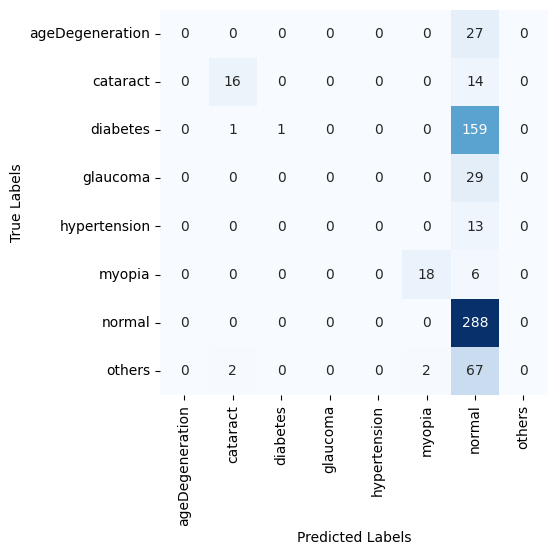

In [32]:
plt.figure(figsize=(5, 5))
hmap = sns.heatmap(confusion, annot=True, vmin=0,
                 fmt='g', cmap='Blues', cbar=False,
                 xticklabels=classes_names,
                 yticklabels=classes_names)

hmap.set(xlabel='Predicted Labels')
hmap.set(ylabel='True Labels')
plt.show()

In [33]:
#Extract wrong classification index
wrong_pred = np.where(y_pred!=y_true)[0]
print(f'Total of {len(wrong_pred)} missclassified images')
print('Missclassified images index: ',wrong_pred)

Total of 320 missclassified images
Missclassified images index:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  32  33  34  35  39  42
  45  46  49  53  54  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 24

In [ ]:
class_map = {0: 'ageDegeneration', 1: 'cataract', 2: 'diabetes', 3:'glaucoma', 4:'hypertension', 5:'myopia', 6:'normal', 7:'others'}

plt.figure(figsize=(10, 5))
for i, index in enumerate(wrong_pred):
    plt.subplot(1, len(wrong_pred), i + 1)

    # reverting scalling (done in preprocessing stage)
    plt.imshow((images[index]*255).astype('uint8'))

    plt.text(5, 10, f"True: {class_map[int(true_labels[index])]}",
             color='green', bbox=dict(facecolor='white', alpha=0.6))
    plt.text(5, 30, f"Pred: {class_map[y_pred[index]]}",
             color='red', bbox=dict(facecolor='white', alpha=0.6))

    plt.axis('off')
plt.tight_layout()
plt.show()